# Spaceship Titanic
Predict which passengers are transported to an alternate dimension

## Introduction
Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

<img src="https://storage.googleapis.com/kaggle-media/competitions/Spaceship%20Titanic/joel-filipe-QwoNAhbmLLo-unsplash.jpg" width=600>

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

Help save them and change history!

## Libraries installing and dataset downloading

In [1]:
%%capture

! pip install kaggle
! pip install numpy
! pip install pandas
! pip install sklearn
! pip install matplotlib
! pip install seaborn
! pip install statsmodels

In [2]:
# Flag to force to reload dataset
RELOAD = False

In [3]:
import os
from zipfile import ZipFile

# import Kaggle API to load dataset
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi

# initialize Kaggle API
api = KaggleApi()
api.authenticate()

# download dataset from Kaggle to data folder
data_path = 'data'
api.competition_download_files('spaceship-titanic', data_path, force=RELOAD, quiet=False)

dataset_file_name = 'spaceship-titanic.zip'


with ZipFile(os.path.join(data_path, dataset_file_name), 'r') as zip_ref:
    zip_ref.extractall(data_path)

spaceship-titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


## Data description
* **train.csv** - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
    - `PassengerId` - A unique Id for each passenger. Each Id takes the form `gggg_pp` where `gggg` indicates a group the passenger is travelling with and `pp` is their number within the group. People in a group are often family members, but not always.
    - `HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.
    - `CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
    - `Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
    - `Destination` - The planet the passenger will be debarking to.
    - `Age` - The age of the passenger.
    - `VIP` - Whether the passenger has paid for special VIP service during the voyage.
    - `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
    - `Name` - The first and last names of the passenger.
    - `Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
* **test.csv** - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of `Transported` for the passengers in this set.
* **sample_submission.csv** - A submission file in the correct format.
    - `PassengerId` - Id for each passenger in the test set.
    - `Transported` - The target. For each passenger, predict either `True` or `False`.

In [4]:
import pandas as pd

# Load data to variables
df = pd.read_csv(os.path.join(data_path, 'train.csv'))                                          # This dataset will be split on train-test-val
df_kaggle_test = pd.read_csv(os.path.join(data_path, 'test.csv'))                               # This dataset doesn't have labels, so will not be used for any of analysis/modeling, only final prediction
df_kaggle_sample_submission = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'))     # This is an example of submission 

In [5]:
# Check shapes of loaded df's
print(f'Shape of df: {str(df.shape)}')
print(f'Shape of df_kaggle_test: {str(df_kaggle_test.shape)}')
print(f'Shape of df_kaggle_sample_submission: {str(df_kaggle_sample_submission.shape)}')

Shape of df: (8693, 14)
Shape of df_kaggle_test: (4277, 13)
Shape of df_kaggle_sample_submission: (4277, 2)


## Exploratory Data Analysis

First, let's take a look on df, it's head and structure

In [6]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [7]:
df.columns.to_list()

['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Name',
 'Transported']

### Univariate analysis

#### PassengerId

In [8]:
# All passengerIDs should be unique, but let's check
print(f'Unique passangerIDs: {len(df.PassengerId.unique())} out of {len(df)} total records')

Unique passangerIDs: 8693 out of 8693 total records


Many passengers travel in groups (see field descriptiuon), let's extract group number from passengerID

In [9]:
df[['GroupId', 'PassengerId_no_group']] = df['PassengerId'].str.split('_', expand=True)

In [10]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,GroupId,PassengerId_no_group
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,01
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,01
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,01
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,02
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,01


In [11]:
# Check number of groups
print(f'Unique GroupIDs: {len(df.GroupId.unique())} out of {len(df)} total records')

Unique GroupIDs: 6217 out of 8693 total records


In [12]:
# Maximum and minimum amount of passangers in each group
df.groupby('GroupId')['PassengerId'].count().max(), df.groupby('GroupId')['PassengerId'].count().min()

(8, 1)

In [13]:
# Add group size as column
df = pd.merge(df, df.groupby('GroupId')['PassengerId'].count(), on='GroupId')
# Rename columns, that they are more meaningful
df.rename({'PassengerId_y': 'Group_size', 'PassengerId_x': 'Full_Id', 'PassengerId_no_group': 'PassengerId'}, axis=1, inplace=True)

In [14]:
df.head()

,Full_Id,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,GroupId,PassengerId,Group_size
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,01,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,01,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,01,2
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,02,2
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,01,1


In [15]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    '''
    https://stackoverflow.com/a/18926541
    '''
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap)
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def plot_groups(column, df=df, xlabel='', ylablel='', title=''):
    grouped_df = df.groupby([column]).size()

    plt.figure(figsize=(10,5))

    data_norm = [(x) / max(grouped_df) for x in grouped_df]
    my_cmap = plt.cm.get_cmap('PuBu')
    my_cmap = truncate_colormap(my_cmap, 0.4, 0.8)
    #new_cmap = sub_cmap(my_cmap, 0.2, 0.9)
    colors = my_cmap(data_norm)

    # df.groupby(['Group_size']).size().plot(kind='bar', rot=0, colormap = 'flag')
    grouped_df.plot(kind='bar', rot=0, color=colors)
    plt.xlabel(xlabel)
    plt.ylabel(ylablel)
    plt.title(title)
    plt.show();


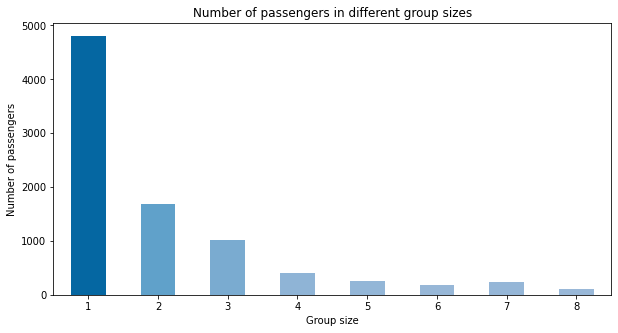

In [16]:
# Group size visualization
plot_groups('Group_size', xlabel='Group size', ylablel='Number of passengers', title='Number of passengers in different group sizes')

About half of the passengers in the test set traveled alone. Groups of 2 or 3 people are also common. 

#### HomePlanet

In [17]:
# HomePlanet field
df['HomePlanet'].unique()

array(['Europa', 'Earth', 'Mars', nan], dtype=object)

In [18]:
df['HomePlanet'].isna().sum()

201

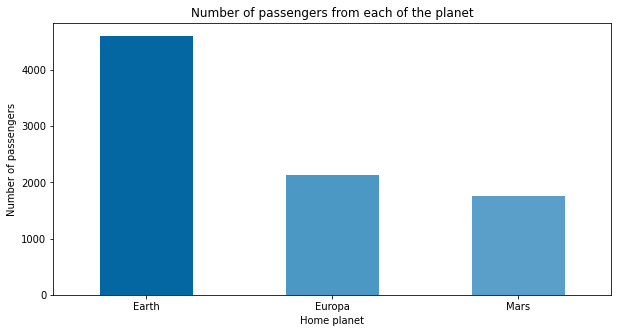

In [19]:
# How many passengers from each of the planet
plot_groups('HomePlanet', xlabel='Home planet', ylablel='Number of passengers', title='Number of passengers from each of the planet')

Only three home planets are in data. 201 records (out of 8693) are missing.

About half of the passengers are from Earth.

#### CryoSleep

In [20]:
df['CryoSleep'].unique()

array([False, True, nan], dtype=object)

In [21]:
df['CryoSleep'].isna().sum()

217

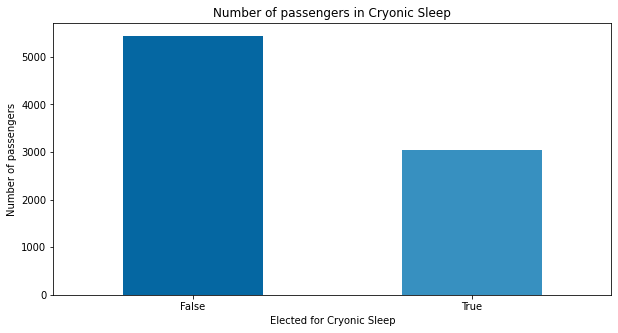

In [22]:
plot_groups('CryoSleep', xlabel='Elected for Cryonic Sleep', ylablel='Number of passengers', title='Number of passengers in Cryonic Sleep')

Options are False or True, 217 (out of 8693) values are missing

About 1/3 of the passengers from test set were elected for CryoSleep

#### Cabin

In [23]:
df['Cabin'].nunique()

6560

In [24]:
df['Cabin'].isna().sum()

199

Amount of unique cabin numbers is less than passengers number. So, not all passengers travelled in own cabin. Let's plot how many passengers were in the one cabin.

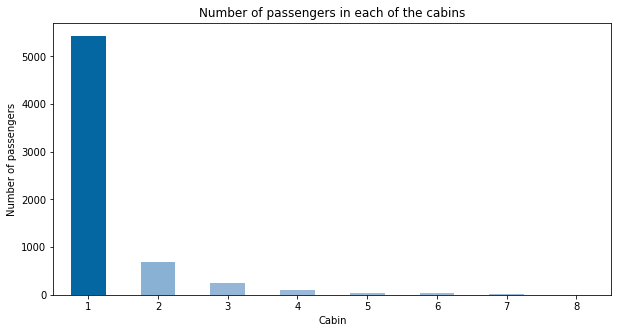

In [25]:
by_cabins_df = pd.DataFrame(df.groupby(by='Cabin').size())
plot_groups(0, df=by_cabins_df, xlabel='Cabin', ylablel='Number of passengers', title='Number of passengers in each of the cabins')

More than half of the passengers travelled alone in their cabins.

Cabin contains deck number, number of cabin on deck and side (P for Port or S for Starboard). Let's extract this information.

In [26]:
df[['Deck', 'Num', 'Side']] = df['Cabin'].str.split('/', expand=True)

In [27]:
df.head()

,Full_Id,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,GroupId,PassengerId,Group_size,Deck,Num,Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,01,1,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,01,1,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,01,2,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,02,2,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,01,1,F,1,S


In [28]:
df['Deck'].unique()

array(['B', 'F', 'A', 'G', nan, 'E', 'D', 'C', 'T'], dtype=object)

In [29]:
# Total number of unique cabin numbers
df['Num'].nunique()

1817

In [30]:
# Number of unique cabin numbers on each deck
df.groupby(by='Deck')['Num'].nunique()

Deck
A      97
B     312
C     301
D     251
E     527
F    1620
G    1341
T       4
Name: Num, dtype: int64

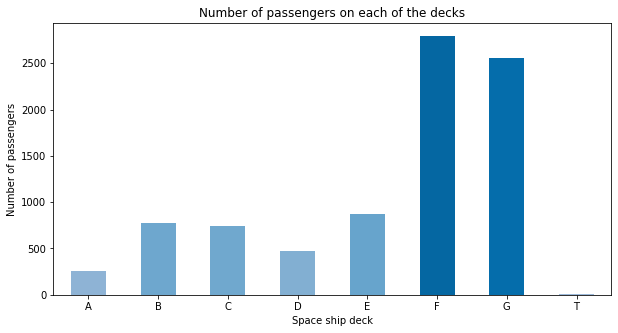

In [31]:
plot_groups('Deck', xlabel='Space ship deck', ylablel='Number of passengers', title='Number of passengers on each of the decks')

Most of the passengers had a cabin on decks `F` and `G`, which correlated with amount of cabins on each of the decks

In [32]:
df['Side'].unique()

array(['P', 'S', nan], dtype=object)

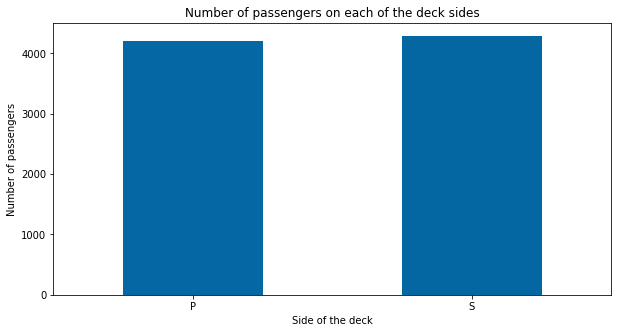

In [33]:
plot_groups('Side', xlabel='Side of the deck', ylablel='Number of passengers', title='Number of passengers on each of the deck sides')

Approximately the same amount of passengers cabins were located on each of spaceship sides.

199 records (out of 8693) are missing.

#### Destination

In [34]:
df['Destination'].nunique()

3

In [35]:
df['Destination'].isna().sum()

182

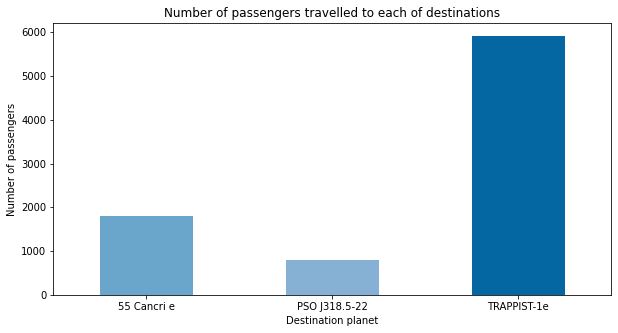

In [36]:
plot_groups('Destination', xlabel='Destination planet', ylablel='Number of passengers', title='Number of passengers travelled to each of destinations')

Vast majority of the passengers travelled to TRAPPIST-1e (https://en.wikipedia.org/wiki/TRAPPIST-1e), second popular destination is 55 Cancri e (https://en.wikipedia.org/wiki/55_Cancri_e), and finally, less than 1000 passenger travelled to PSO J318.5-22 (https://en.wikipedia.org/wiki/PSO_J318.5%E2%88%9222), which doesn't orbit a parent star.

182 (out of 8693) destination records are missing

#### Age

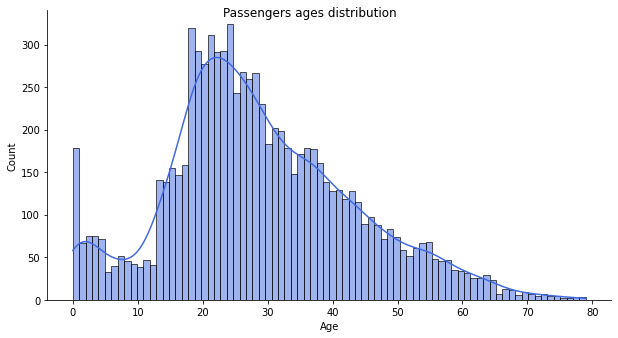

In [37]:
import seaborn as sns
g = sns.displot(df['Age'], kde=True, bins=80, color = 'royalblue', height=4.75, aspect=1.83)
g.fig.suptitle("Passengers ages distribution");

In [38]:
df['Age'].describe()

count    8514.000000
mean       28.827930
std        14.489021
min         0.000000
25%        19.000000
50%        27.000000
75%        38.000000
max        79.000000
Name: Age, dtype: float64

In [39]:
df['Age'].isna().sum()

179

Age distribution density plot looks like Positively skewed distribution with additional peak on the left. Half of the passengers are in between 19 and 38 years old, and also many children 0-5 years.

179 passengers (out of 8693) don't have age indicated

#### VIP

In [40]:
df['VIP'].unique()

array([False, True, nan], dtype=object)

In [41]:
df['VIP'].isna().sum()

203

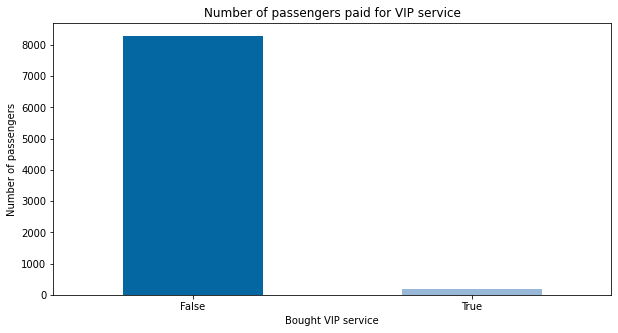

In [42]:
plot_groups('VIP', xlabel='Bought VIP service', ylablel='Number of passengers', title='Number of passengers paid for VIP service')

Only small part of the passengers had paid for VIP service. 203 records are missing

### Mony spent on additional services (RoomService, FoodCourt, ShoppingMall, Spa, VRDeck)

In [43]:
df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].describe()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,224.687617,458.077203,173.729169,311.138778,304.854791
std,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,47.000000,76.000000,27.000000,59.000000,46.000000
max,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


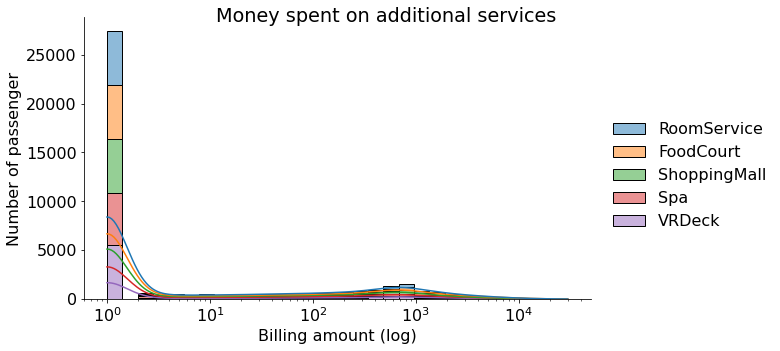

In [189]:
g = sns.displot(df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]+1, kde=True, bins=30, multiple="stack", height=4.75, aspect=1.83, log_scale=(True,False))
g.set_axis_labels("Billing amount (log)", "Number of passengers")
g.fig.suptitle("Money spent on additional services");

In [45]:
df['RoomService'].isna().sum(), df['FoodCourt'].isna().sum(), df['ShoppingMall'].isna().sum(), df['Spa'].isna().sum(), df['VRDeck'].isna().sum()

(181, 183, 208, 183, 188)

Most of the passengers didn't spend money on all additional services, less than 25% of passengers spent large amounts on some of them.
About 180-200 records for each of these columns are missing.

#### Name

In [46]:
df['Name'].isna().sum()

200

In [47]:
df['Name'].nunique()

8473

In [48]:
len(df[(df.duplicated('Name')) & ~df['Name'].isna()])

20

200 passengers didn't indicate their names and 20 of them had full namesakes on the Spaceship

In [49]:
# Split Name for First Name and Last Name
df[['First_name', 'Last_name']] = df['Name'].str.split(' ', expand=True)

In [50]:
df.head()

,Full_Id,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name,Transported,GroupId,PassengerId,Group_size,Deck,Num,Side,First_name,Last_name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,Maham Ofracculy,False,0001,01,1,B,0,P,Maham,Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,Juanna Vines,True,0002,01,1,F,0,S,Juanna,Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,Altark Susent,False,0003,01,2,A,0,S,Altark,Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,Solam Susent,False,0003,02,2,A,0,S,Solam,Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,Willy Santantines,True,0004,01,1,F,1,S,Willy,Santantines


In [51]:
len(df[(df.duplicated('First_name')) & ~df['First_name'].isna()]), len(df[(df.duplicated('Last_name')) & ~df['Last_name'].isna()])

(5787, 6276)

About of 3/4 of first and last names are not unique among the passengers of the SpaceShip

#### Transported

In [52]:
df['Transported'].isna().sum()

0

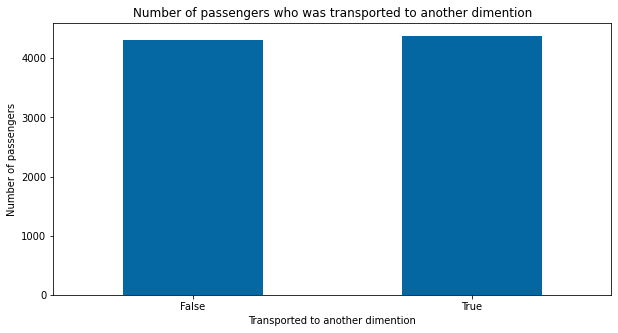

In [53]:
plot_groups('Transported', xlabel='Transported to another dimention', ylablel='Number of passengers', title='Number of passengers who was transported to another dimention')

About half of the passengers were sent to alternate dimension

#### Univariate analysis conclusion

- Train dataset contains 8693 records
- Each entry contains unique Passenger ID, based on it we can find size of the group (e.g. family or friends) of passengers who travel together: Most of the passengers traveled alone or in 2 or 3 persons groups
- About half of the passengers were from Earth, another half from Europa and Mars
- About 1/3 of the passengers were in Cryonic Sleep during the travel
- More than half passengers travelled in separate cabin, some shared their cabin 2, 3 or more people (more people in cabin - more rare)
- Ship has 8 decks, with different number of cabins on each deck. Decks F and G has the most cabins and also most of the passengers are from these decks
- There were almost equal number of passengers on each side of the deck
- About 2/3 of the passengers travelled to TRAPPIST-1e
- Passengers were from 0 up to 79 years old, with half of them between 19 and 38 years old. Distribution of ages is not standard, as could be expected: there were many 0 years old babies onboard, but not so many 5-15 years old passengers
- Almost nobody bought VIP service
- Most of the passengers didn't spend money on additional services, but some of them spent a lot
- 20 passengers have full namesakes travelling with them
- Half of all passengers were transported to another dimention 
- Each column, except `PassengerId` and `Transported` have about 200 NaN values

### Multivariate analysis

#### Correlation matrix

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8693 entries, 0 to 8692
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Full_Id       8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
 14  GroupId       8693 non-null   object 
 15  PassengerId   8693 non-null   object 
 16  Group_size    8693 non-null   int64  
 17  Deck          8494 non-null   object 
 18  Num           8494 non-null 

In [55]:
# Transform some object columns to categorical or boolean
df = df.astype({'HomePlanet':'category', 'CryoSleep':'bool', 'Destination':'category', 'VIP':'bool', 'Deck':'category', 'Side':'category'})
# Side will be IsPortSide and boolean - don't do now, not needed for EDA and one-hot encoding will be done later during data preparation for training
#df['IsPortSide'] = (df['Side'] == 'P')

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8693 entries, 0 to 8692
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Full_Id       8693 non-null   object  
 1   HomePlanet    8492 non-null   category
 2   CryoSleep     8693 non-null   bool    
 3   Cabin         8494 non-null   object  
 4   Destination   8511 non-null   category
 5   Age           8514 non-null   float64 
 6   VIP           8693 non-null   bool    
 7   RoomService   8512 non-null   float64 
 8   FoodCourt     8510 non-null   float64 
 9   ShoppingMall  8485 non-null   float64 
 10  Spa           8510 non-null   float64 
 11  VRDeck        8505 non-null   float64 
 12  Name          8493 non-null   object  
 13  Transported   8693 non-null   bool    
 14  GroupId       8693 non-null   object  
 15  PassengerId   8693 non-null   object  
 16  Group_size    8693 non-null   int64   
 17  Deck          8494 non-null   category
 18  Num     

In [58]:
# Factorize categorical variables to build correlation matrix for initial correlation estimation
df_factor=df.drop(['Full_Id', 'Cabin', 'Name', 'GroupId', 'PassengerId', 'Num', 'First_name', 'Last_name'], axis=1).apply(lambda x : pd.factorize(x)[0])+1

In [59]:
df_factor.describe()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group_size,Deck,Side
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,1.910963,1.374324,1.484758,27.390774,1.046244,151.862878,186.099505,119.595076,157.578742,149.496261,1.503624,2.077304,3.438169,1.470378
std,0.729458,0.483976,0.840148,17.653102,0.210025,300.284143,363.294969,249.579829,308.947191,300.786490,0.500016,1.670032,1.809941,0.543084
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,12.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000
50%,2.000000,1.000000,1.000000,28.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,4.000000,1.000000
75%,2.000000,2.000000,2.000000,40.000000,1.000000,127.000000,166.000000,78.000000,130.000000,123.000000,2.000000,3.000000,4.000000,2.000000
max,3.000000,2.000000,3.000000,80.000000,2.000000,1273.000000,1507.000000,1115.000000,1327.000000,1306.000000,2.000000,8.000000,8.000000,2.000000


In [60]:
df_factor.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   HomePlanet    8693 non-null   int64
 1   CryoSleep     8693 non-null   int64
 2   Destination   8693 non-null   int64
 3   Age           8693 non-null   int64
 4   VIP           8693 non-null   int64
 5   RoomService   8693 non-null   int64
 6   FoodCourt     8693 non-null   int64
 7   ShoppingMall  8693 non-null   int64
 8   Spa           8693 non-null   int64
 9   VRDeck        8693 non-null   int64
 10  Transported   8693 non-null   int64
 11  Group_size    8693 non-null   int64
 12  Deck          8693 non-null   int64
 13  Side          8693 non-null   int64
dtypes: int64(14)
memory usage: 1018.7 KB


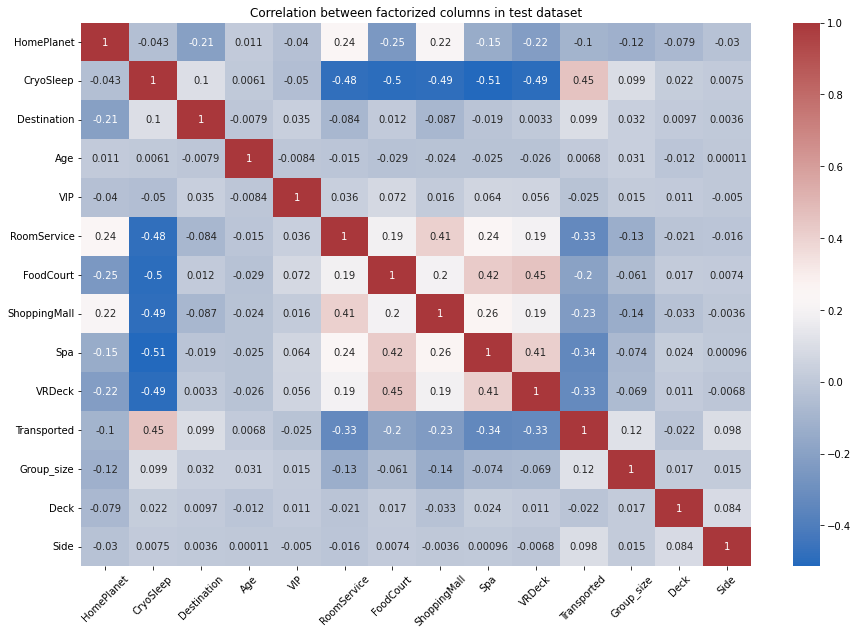

In [67]:
# Use Spearman correlation (https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient)
corr = df_factor.corr(method='spearman')
plt.figure(figsize=(15,10))
sns.heatmap(corr, cmap = 'vlag', annot=corr)
plt.xticks(rotation=45) 
plt.title('Correlation between factorized columns in test dataset')
plt.show();
del df_factor


From the heatmap of correlation we can extract the following information:
- `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, and `VRDeck` columns show negative correlation with `CryoSleep` column: indeed, passengers who spent more time in cryonic sleep didn't have an opportunity to spend a lot of money in ship's facilities
- `HomePlanet` and `Destination` show some correlation. People from certain home planet may prefer some specific destination
- There is also correlation between `HomePlanet` and money spent on ship's facilities. But correlation changes its sign, so passengers from some planets prefer to spend more time on VRDeck and in Food Court, while the one from another planet likes to spend money on Room Service and in Shopping Mall. Correlation between `HomePlanet` and `Spa` relatively weaker, compare to other ship's facilities
- `Age` doesn't show any meaningful correlation with other columns, as well as `VIP` status
- `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, and `VRDeck` also show positive correlation with each other, which means that people who are ready to spend money on one of such a service, would also spend some amount on another. We can see, that `RoomService` has stronger correlation with `ShoppingMall`, while `FoodCourt` correlates stronger with `Spa` and `VRDeck`
- `Group_size` have some weak negative correlation with `RoomService` and `ShoppingMall`, large groups spend less money on such services
- `Deck` and deck `Side` don't show correlation with another columns
- `Transported` is a column which has to be predicted. Based on test data, we can see that it has positive correlation with `CryoSleep`, negative correlation with ship's facility (as was mentioned above, they are correlated with `CryoSleep` as well) and weak positive correlation with `Group_size`


#### Home Planet

Let's check, how Home planet related with other columns

##### Home Planet vs. CryoSleep

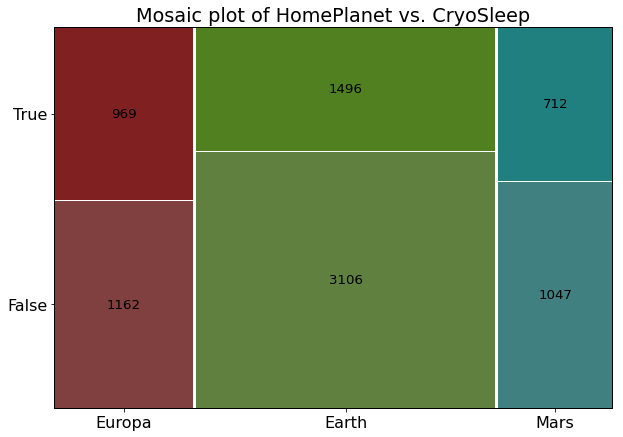

In [162]:
from statsmodels.graphics.mosaicplot import mosaic
plt.rcParams['font.size'] = 16.0
plt.rcParams['figure.figsize'] = (10,7)
lab = lambda k: len(df[(df['HomePlanet'] == k[0]) & (df['CryoSleep'] == bool(k[1]=='True'))])
mosaic(df, ['HomePlanet', 'CryoSleep'], labelizer=lab, title='Mosaic plot of HomePlanet vs. CryoSleep');

Chi-sqaure test. 

Null hypothesis: `HomePlanet` and `CryoSleep` have no association or correlation amongst them

In [95]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2

ct_table_ind=pd.crosstab(df['HomePlanet'], df['CryoSleep'])
chi2_stat, p, dof, expected = chi2_contingency(ct_table_ind)

print(f"chi2 statistic:     {chi2_stat:.5g}")
print(f"p-value:            {p:.5g}")
print(f"degrees of freedom: {dof}")

significance_level = 0.05
if p <= significance_level:
    print('Reject Null Hypothesis')
else:
    print('Accept Null Hypothesis')    


chi2 statistic:     113.45
p-value:            2.3157e-25
degrees of freedom: 2
Reject Null Hypothesis


Null hypothesis is rejected, `HomePlanet` and `CryoSleep` have association or correlation amongst them. 

From mosaic plot, we see, that significantly less people from Earth (less than a half) were elected for cryonic sleep, while about 90% travellers from Europa and about 70% from Mars were elected for cryonic sleep and were confined in their cabines 

##### Home Planet vs. Destination

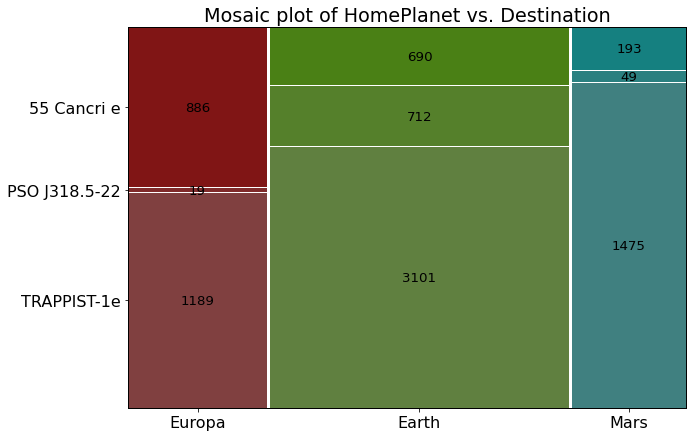

In [164]:
lab = lambda k: len(df[(df['HomePlanet'] == k[0]) & (df['Destination'] == k[1])])
mosaic(df, ['HomePlanet', 'Destination'], labelizer=lab, title='Mosaic plot of HomePlanet vs. Destination');

Chi-sqaure test. 

Null hypothesis: `HomePlanet` and `Destination` have no association or correlation amongst them

In [166]:
ct_table_ind=pd.crosstab(df['HomePlanet'], df['Destination'])
chi2_stat, p, dof, expected = chi2_contingency(ct_table_ind)

print(f"chi2 statistic:     {chi2_stat:.5g}")
print(f"p-value:            {p:.5g}")
print(f"degrees of freedom: {dof}")

significance_level = 0.05
if p <= significance_level:
    print('Reject Null Hypothesis')
else:
    print('Accept Null Hypothesis')    

chi2 statistic:     1144.2
p-value:            2.0026e-246
degrees of freedom: 4
Reject Null Hypothesis


Chi-square test rejects our null hypothesis that there is no correlation between `HomePlanet` and `Destination`.
Almost half of travellers from Europa were going to 55 Cancri e, and almost nobody to PSO J318.5-22. Travellers from Mars also don't prefer PSO J318.5-22, but they also avoid 55 Cancri e. Travelers from Earth were mostly directed to TRAPPIST-1e, but 1/4 of them were, with almost equally proportion, travelling to other two possible destinations

##### HomePlanet vs. Age

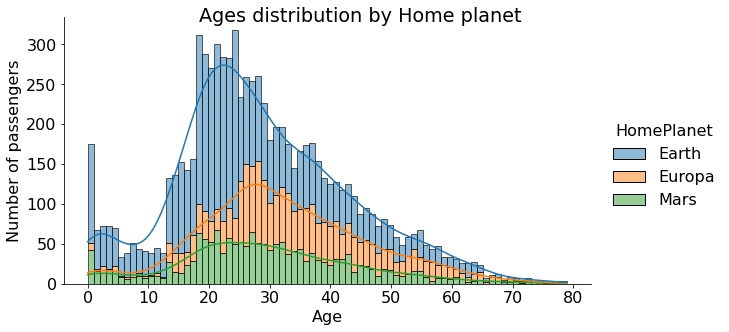

In [190]:
g = sns.displot(df, x='Age', kde=True, bins=80, color = 'royalblue', height=4.75, aspect=1.83, hue='HomePlanet', multiple="stack")
g.set_axis_labels("Age", "Number of passengers")
g.fig.suptitle("Ages distribution by Home planet");

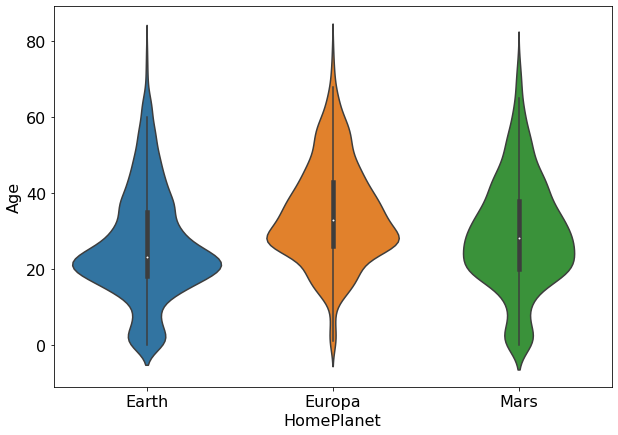

In [196]:
ax = sns.violinplot(x='HomePlanet', y='Age', data=df)

ANOVA (Analysis of Variance) test.

Null hypothesis: Ages distributions for passengers from different HomePlanet are equal

In [207]:
from scipy.stats import f_oneway

df_ages = df[~df['Age'].isna()][['HomePlanet', 'Age']]
anova_stat, p = f_oneway(df_ages[df_ages['HomePlanet']=='Earth']['Age'], df_ages[df_ages['HomePlanet']=='Europa']['Age'], df_ages[df_ages['HomePlanet']=='Mars']['Age'])

In [209]:
print(f"ANOVA statistic:     {anova_stat:.5g}")
print(f"p-value:            {p:.5g}")

significance_level = 0.05
if p <= significance_level:
    print('Reject Null Hypothesis')
else:
    print('Accept Null Hypothesis')    

chi2 statistic:     252.41
p-value:            3.787e-107
Reject Null Hypothesis


Null hypothesis is rejected. From plots we can see, that from Europa only few passengers (compare to other home planets) younger than 13 years old. Also, travellers from Earth are younger in avarege, than from other planets. Europa has the oldest in average travellers.

##### HomePlanet vs. VIP

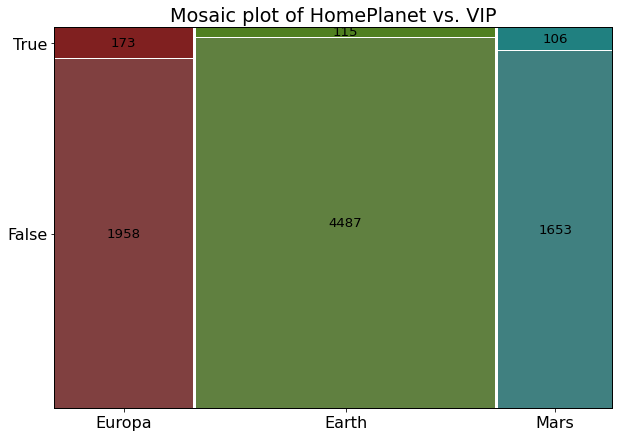

In [211]:
lab = lambda k: len(df[(df['HomePlanet'] == k[0]) & (df['VIP'] == bool(k[1]=='True'))])
mosaic(df, ['HomePlanet', 'VIP'], labelizer=lab, title='Mosaic plot of HomePlanet vs. VIP');

Chi-sqaure test. 

Null hypothesis: `HomePlanet` and `VIP` have no association or correlation amongst them

In [212]:
ct_table_ind=pd.crosstab(df['HomePlanet'], df['VIP'])
chi2_stat, p, dof, expected = chi2_contingency(ct_table_ind)

print(f"chi2 statistic:     {chi2_stat:.5g}")
print(f"p-value:            {p:.5g}")
print(f"degrees of freedom: {dof}")

significance_level = 0.05
if p <= significance_level:
    print('Reject Null Hypothesis')
else:
    print('Accept Null Hypothesis')    

chi2 statistic:     113.59
p-value:            2.1562e-25
degrees of freedom: 2
Reject Null Hypothesis


Chi-square test rejects our null hypothesis that there is no correlation between `HomePlanet` and `VIP` service.
Only small part (about 2.5%) of Earth travellers bought VIP service, compare to Europa (about 9%) and Mars (about 6.5%)

##### HomePlanet vs. RoomService

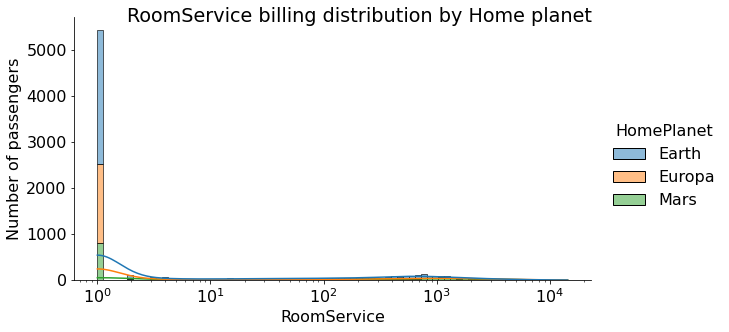

In [239]:
df['RoomService'] = df['RoomService'] + 1   # To avoid error on log_scale
g = sns.displot(df, x='RoomService', kde=True, bins=80, color = 'royalblue', height=4.75, aspect=1.83, hue='HomePlanet', multiple="stack", log_scale=(True,False))
df['RoomService'] = df['RoomService'] - 1   # Restore values
g.set_axis_labels("RoomService", "Number of passengers")
g.fig.suptitle("RoomService billing distribution by Home planet");


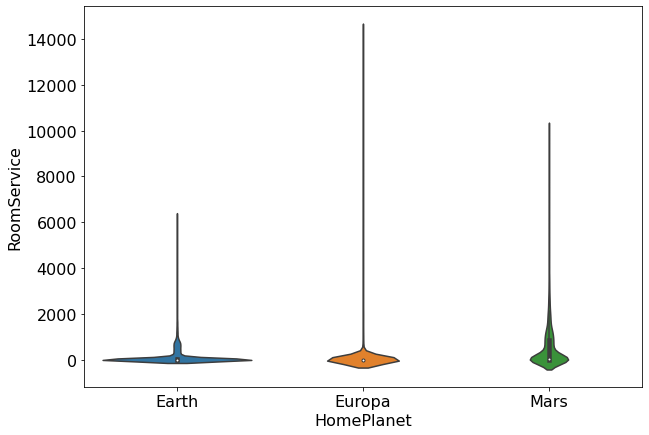

In [240]:
ax = sns.violinplot(x='HomePlanet', y='RoomService', data=df)
#plt.yscale('log')

ANOVA (Analysis of Variance) test.

Null hypothesis: Room Service billing distributions for passengers from different HomePlanet are equal

In [241]:
df_ages = df[~df['RoomService'].isna()][['HomePlanet', 'RoomService']]
anova_stat, p = f_oneway(df_ages[df_ages['HomePlanet']=='Earth']['RoomService'], df_ages[df_ages['HomePlanet']=='Europa']['RoomService'], df_ages[df_ages['HomePlanet']=='Mars']['RoomService'])

In [242]:
print(f"ANOVA statistic:     {anova_stat:.5g}")
print(f"p-value:            {p:.5g}")

significance_level = 0.05
if p <= significance_level:
    print('Reject Null Hypothesis')
else:
    print('Accept Null Hypothesis')    

chi2 statistic:     276.4
p-value:            6.0494e-117
Reject Null Hypothesis


Null hypothesis is rejected. From plots we can see, that while passengers from Earth moslty didn't spend money on Room service, individual travellers from Europa and Mars spent much more.

##### HomePlanet vs. FoodCourt

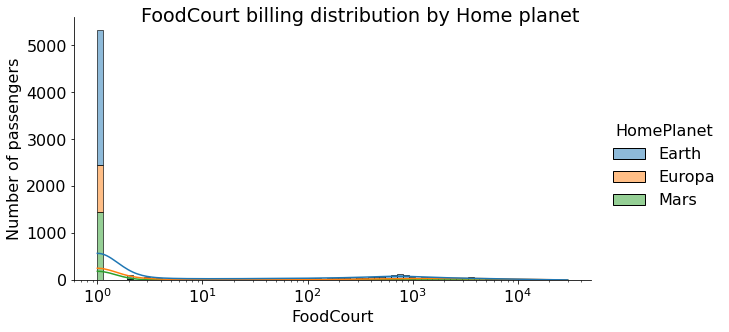

In [243]:
df['FoodCourt'] = df['FoodCourt'] + 1   # To avoid error on log_scale
g = sns.displot(df, x='FoodCourt', kde=True, bins=80, color = 'royalblue', height=4.75, aspect=1.83, hue='HomePlanet', multiple="stack", log_scale=(True,False))
df['FoodCourt'] = df['FoodCourt'] - 1   # Restore values
g.set_axis_labels("FoodCourt", "Number of passengers")
g.fig.suptitle("FoodCourt billing distribution by Home planet");


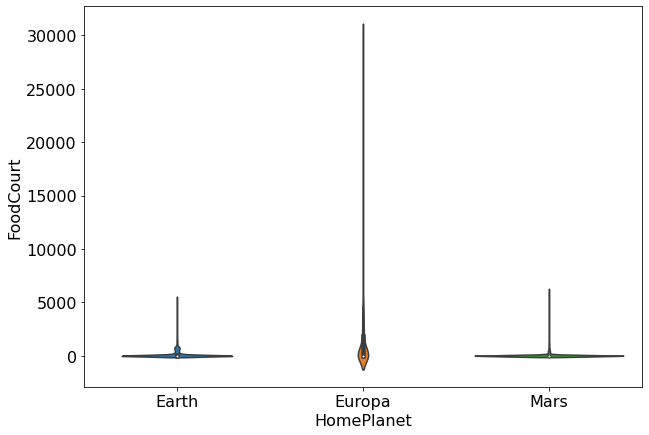

In [244]:
ax = sns.violinplot(x='HomePlanet', y='FoodCourt', data=df)

ANOVA (Analysis of Variance) test.

Null hypothesis: Food Court billing distributions for passengers from different HomePlanet are equal

In [245]:
df_ages = df[~df['FoodCourt'].isna()][['HomePlanet', 'FoodCourt']]
anova_stat, p = f_oneway(df_ages[df_ages['HomePlanet']=='Earth']['FoodCourt'], df_ages[df_ages['HomePlanet']=='Europa']['FoodCourt'], df_ages[df_ages['HomePlanet']=='Mars']['FoodCourt'])

In [246]:
print(f"ANOVA statistic:     {anova_stat:.5g}")
print(f"p-value:            {p:.5g}")

significance_level = 0.05
if p <= significance_level:
    print('Reject Null Hypothesis')
else:
    print('Accept Null Hypothesis')    

chi2 statistic:     661.72
p-value:            2.1651e-267
Reject Null Hypothesis


Null hypothesis is rejected. From plots we can see, that while passengers from Earth and Mars moslty didn't spend money on Room service, individual travellers from Europa spent huge amount.

##### HomePlanet vs. ShoppingMall

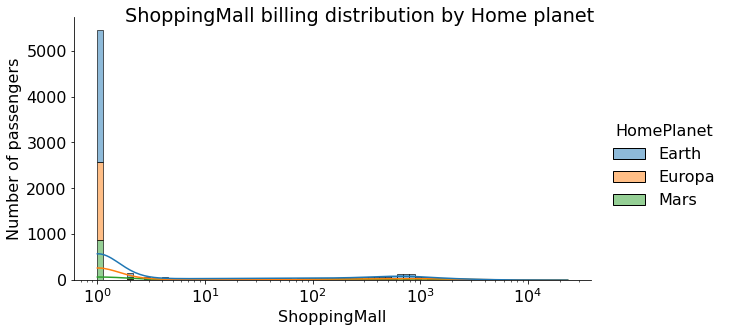

In [247]:
df['ShoppingMall'] = df['ShoppingMall'] + 1   # To avoid error on log_scale
g = sns.displot(df, x='ShoppingMall', kde=True, bins=80, color = 'royalblue', height=4.75, aspect=1.83, hue='HomePlanet', multiple="stack", log_scale=(True,False))
df['ShoppingMall'] = df['ShoppingMall'] - 1   # Restore values
g.set_axis_labels("ShoppingMall", "Number of passengers")
g.fig.suptitle("ShoppingMall billing distribution by Home planet");


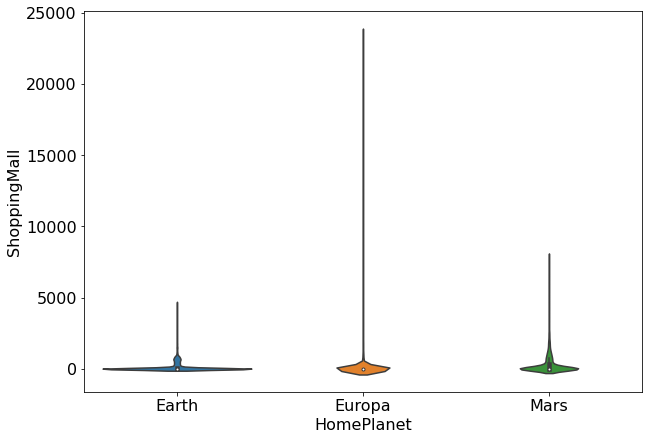

In [248]:
ax = sns.violinplot(x='HomePlanet', y='ShoppingMall', data=df)

ANOVA (Analysis of Variance) test.

Null hypothesis: Shopping Mall billing distributions for passengers from different HomePlanet are equal

In [249]:
df_ages = df[~df['ShoppingMall'].isna()][['HomePlanet', 'ShoppingMall']]
anova_stat, p = f_oneway(df_ages[df_ages['HomePlanet']=='Earth']['ShoppingMall'], df_ages[df_ages['HomePlanet']=='Europa']['ShoppingMall'], df_ages[df_ages['HomePlanet']=='Mars']['ShoppingMall'])

In [250]:
print(f"ANOVA statistic:     {anova_stat:.5g}")
print(f"p-value:            {p:.5g}")

significance_level = 0.05
if p <= significance_level:
    print('Reject Null Hypothesis')
else:
    print('Accept Null Hypothesis')    

ANOVA statistic:     54.541
p-value:            2.934e-24
Reject Null Hypothesis


Null hypothesis is rejected. From plots we can see, that while passengers from Earth and Mars moslty didn't spend money in Shopping Mall, individual travellers from Europa spent huge amount.

##### HomePlanet vs. Spa

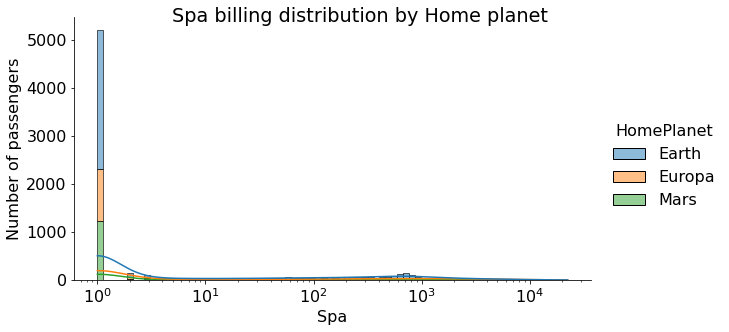

In [251]:
df['Spa'] = df['Spa'] + 1   # To avoid error on log_scale
g = sns.displot(df, x='Spa', kde=True, bins=80, color = 'royalblue', height=4.75, aspect=1.83, hue='HomePlanet', multiple="stack", log_scale=(True,False))
df['Spa'] = df['Spa'] - 1   # Restore values
g.set_axis_labels("Spa", "Number of passengers")
g.fig.suptitle("Spa billing distribution by Home planet");


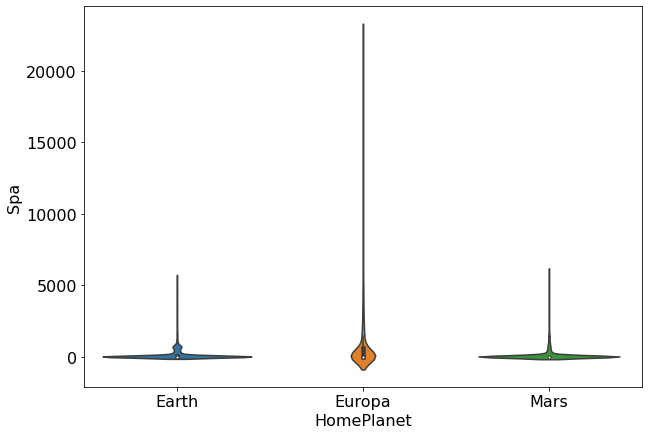

In [252]:
ax = sns.violinplot(x='HomePlanet', y='Spa', data=df)

ANOVA (Analysis of Variance) test.

Null hypothesis: Spa billing distributions for passengers from different HomePlanet are equal

In [253]:
df_ages = df[~df['Spa'].isna()][['HomePlanet', 'Spa']]
anova_stat, p = f_oneway(df_ages[df_ages['HomePlanet']=='Earth']['Spa'], df_ages[df_ages['HomePlanet']=='Europa']['Spa'], df_ages[df_ages['HomePlanet']=='Mars']['Spa'])

In [254]:
print(f"ANOVA statistic:     {anova_stat:.5g}")
print(f"p-value:            {p:.5g}")

significance_level = 0.05
if p <= significance_level:
    print('Reject Null Hypothesis')
else:
    print('Accept Null Hypothesis')    

ANOVA statistic:     332.6
p-value:            1.109e-139
Reject Null Hypothesis


Null hypothesis is rejected. From plots we can see, that while passengers from Earth and Mars moslty didn't spend money for Spa, individual travellers from Europa spent huge amount.

##### HomePlanet vs. VRDeck

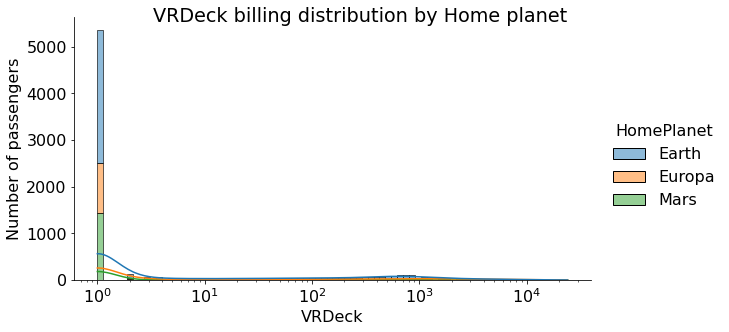

In [255]:
df['VRDeck'] = df['VRDeck'] + 1   # To avoid error on log_scale
g = sns.displot(df, x='VRDeck', kde=True, bins=80, color = 'royalblue', height=4.75, aspect=1.83, hue='HomePlanet', multiple="stack", log_scale=(True,False))
df['VRDeck'] = df['VRDeck'] - 1   # Restore values
g.set_axis_labels("VRDeck", "Number of passengers")
g.fig.suptitle("VRDeck billing distribution by Home planet");


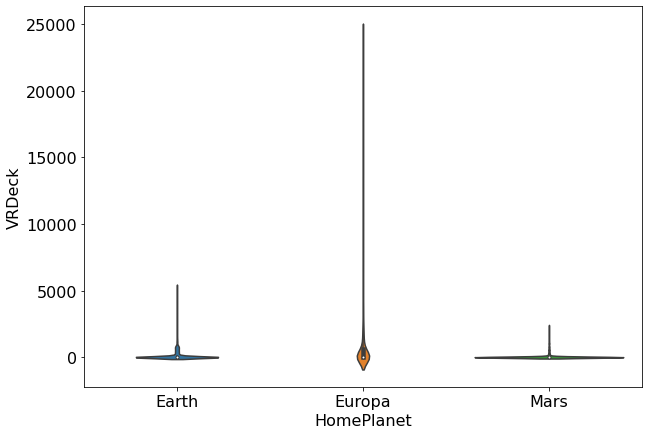

In [256]:
ax = sns.violinplot(x='HomePlanet', y='VRDeck', data=df)

ANOVA (Analysis of Variance) test.

Null hypothesis: VRDeck billing distributions for passengers from different HomePlanet are equal

In [258]:
df_ages = df[~df['VRDeck'].isna()][['HomePlanet', 'VRDeck']]
anova_stat, p = f_oneway(df_ages[df_ages['HomePlanet']=='Earth']['VRDeck'], df_ages[df_ages['HomePlanet']=='Europa']['VRDeck'], df_ages[df_ages['HomePlanet']=='Mars']['VRDeck'])

In [259]:
print(f"ANOVA statistic:     {anova_stat:.5g}")
print(f"p-value:            {p:.5g}")

significance_level = 0.05
if p <= significance_level:
    print('Reject Null Hypothesis')
else:
    print('Accept Null Hypothesis')    

ANOVA statistic:     379.25
p-value:            2.4489e-158
Reject Null Hypothesis


Null hypothesis is rejected. From plots we can see, that while passengers from Earth and Mars moslty didn't spend money for VRDeck, individual travellers from Europa spent huge amount.

Observations are similar for all five spaceship facilities: Most of all passengers didn't spend money on them, but some individuals, especially from Europe, as we can conclude from ANOVA tests and plots, spent a lot for the facilities.

##### HomePlanet vs. GroupSize

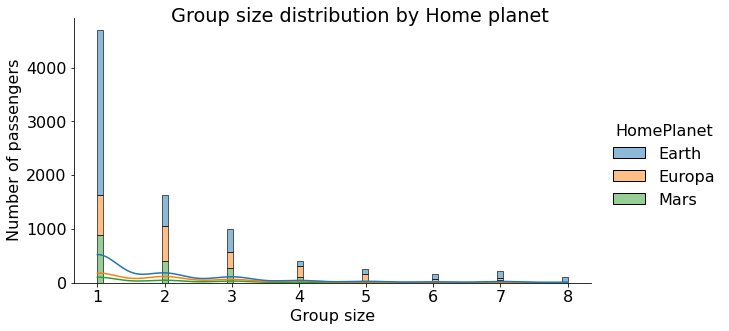

In [261]:
g = sns.displot(df, x='Group_size', kde=True, bins=80, color = 'royalblue', height=4.75, aspect=1.83, hue='HomePlanet', multiple="stack")
g.set_axis_labels("Group size", "Number of passengers")
g.fig.suptitle("Group size distribution by Home planet");


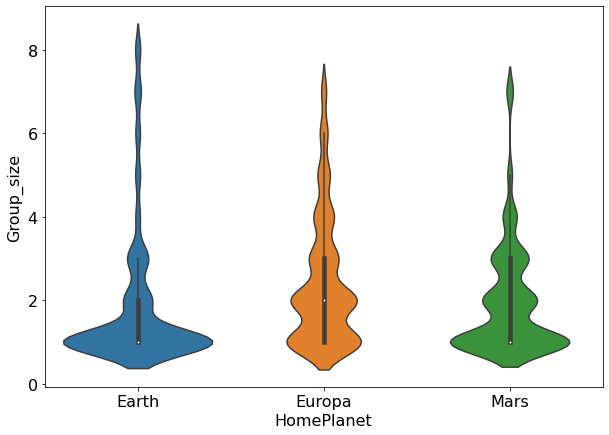

In [262]:
ax = sns.violinplot(x='HomePlanet', y='Group_size', data=df)

ANOVA (Analysis of Variance) test.

Null hypothesis: `Group_size` distributions for passengers from different HomePlanet are equal

In [264]:
df_ages = df[~df['Group_size'].isna()][['HomePlanet', 'Group_size']]
anova_stat, p = f_oneway(df_ages[df_ages['HomePlanet']=='Earth']['Group_size'], df_ages[df_ages['HomePlanet']=='Europa']['Group_size'], df_ages[df_ages['HomePlanet']=='Mars']['Group_size'])

In [265]:
print(f"ANOVA statistic:     {anova_stat:.5g}")
print(f"p-value:            {p:.5g}")

significance_level = 0.05
if p <= significance_level:
    print('Reject Null Hypothesis')
else:
    print('Accept Null Hypothesis')    

ANOVA statistic:     79.183
p-value:            8.4764e-35
Reject Null Hypothesis


Null hypothesis is rejected. We can see, that much more individual travellers from the Earth and large groups (>6 persons) are also mostly from Earth. 

##### Home Planet vs. Deck

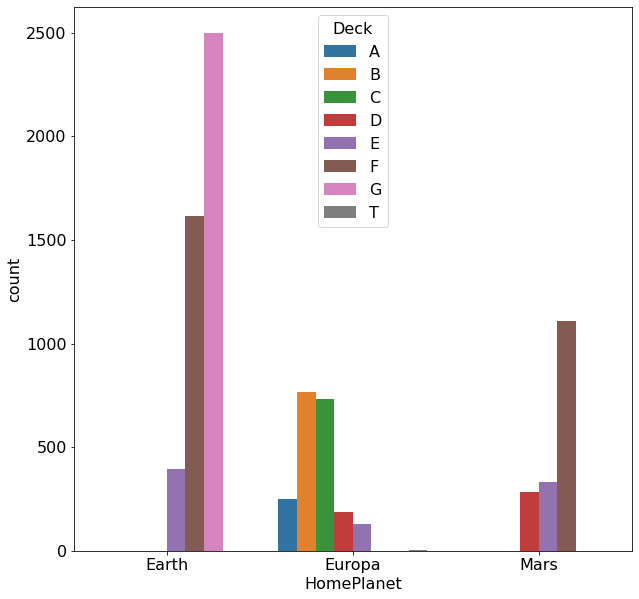

In [293]:
# Mosaic plot is not easy to read when many categories
sns.countplot(data=df, x="HomePlanet", hue="Deck");

Chi-sqaure test. 

Null hypothesis: `HomePlanet` and `Deck` have no association or correlation amongst them

In [294]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2

ct_table_ind=pd.crosstab(df['HomePlanet'], df['Deck'])
chi2_stat, p, dof, expected = chi2_contingency(ct_table_ind)

print(f"chi2 statistic:     {chi2_stat:.5g}")
print(f"p-value:            {p:.5g}")
print(f"degrees of freedom: {dof}")

significance_level = 0.05
if p <= significance_level:
    print('Reject Null Hypothesis')
else:
    print('Accept Null Hypothesis')    


chi2 statistic:     9426
p-value:            0
degrees of freedom: 14
Reject Null Hypothesis


Null hypothesis is rejected, `HomePlanet` and `Deck` have association or correlation amongst them. 

From bar plot, we see, that decks A, B and C are occupied only by Europa passengers. Deck D is shared between Europeans and Marsians (slightly more Marsians). Deck E is shared among travellers from all planets (slightly less Europeans). Deck F is occupied by Terrenians and some less, but still significant number of Marsians. On the deck G, only Terrenians can be found and 4 Europeans have cabins on deck T.

##### HomePlanet vs. Side

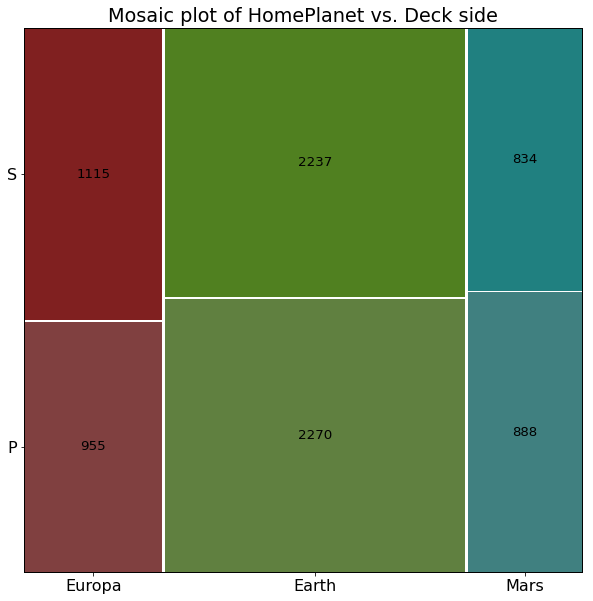

In [295]:
lab = lambda k: len(df[(df['HomePlanet'] == k[0]) & (df['Side'] == k[1])])
mosaic(df, ['HomePlanet', 'Side'], labelizer=lab, title='Mosaic plot of HomePlanet vs. Deck side');

Chi-sqaure test. 

Null hypothesis: `HomePlanet` and `Side` have no association or correlation amongst them

In [296]:
ct_table_ind=pd.crosstab(df['HomePlanet'], df['Side'])
chi2_stat, p, dof, expected = chi2_contingency(ct_table_ind)

print(f"chi2 statistic:     {chi2_stat:.5g}")
print(f"p-value:            {p:.5g}")
print(f"degrees of freedom: {dof}")

significance_level = 0.05
if p <= significance_level:
    print('Reject Null Hypothesis')
else:
    print('Accept Null Hypothesis')    

chi2 statistic:     13.661
p-value:            0.0010803
degrees of freedom: 2
Reject Null Hypothesis


Chi-square test rejects our null hypothesis that there is no correlation between `HomePlanet` and `Side` of the deck. While passengers from Earth and Mars are approximately equaly distributed between decks sides, travellers from Europe have prevalence on S side